## **Automatic stratification of Tabular data using MDSS**

The goal of AutoStrat is to identify sub-populations who, as a group, have outcomes that significantly diverge from the overall population.

There are $\prod_{m=1}^{M}\left(2^{|X_{m}|}-1\right)$ unique subgroups from a dataset with $M$ features, with each feature having $|X_{m}|$ discretized values, where a subgroup is any $M$-dimension Cartesian set product, between subsets of feature-values from each feature --- excluding the empty set. MDSS mitigates this computational hurdle by approximately identifing the most statistically divergent subgroup in linear time (rather than exponential).




In this example, we have the 2014 and 2018 US Census-Income datasets, each of ~1.6 Million records where we observe a given individual represented by their census data as earning more than $50k/yr or not. These datasets are obtained from the [Folktables Python package](https://github.com/zykls/folktables) which provides access to datasets derived from the US Census. For the sake of these demo, we will sample only 100K records but feel free to use the whole dataset for your practice.

Since the outcome is binary, we can use a Bernoulli scoring function. Other scoring functions eg.`Poisson` may be appropriate for your dataset depending on the parametric assumptions of the outcome. In scenarios where we do not wish to make any parametric assumptions a scoring function like `BerkJones` may be more appropriate

Import the MDSS module and Bernoulli modules

In [1]:
from aif360.detectors.mdss_detector import bias_scan
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

# set the seed to reproduce results
np.random.seed(0)

We'll load the csv file obtained from the preprocessing notebook which downloads the data from Folktables. Note that the data containes categorical features and continous features have been binned. When applying autostrat, it is important that categorical features are not one-hot encoded as this may result in subsets that have individuals belonging to two different categories. The cardinality of each feature also influences run-time.

### Data

In [20]:
dff_2014 = pd.read_csv('sampled_folktables_income_2014.csv')
dff_2018 = pd.read_csv('sampled_folktables_income_2018.csv')

In [3]:
dff_2014.head(2)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,observed
0,20 - 30,State government employee,Master’s degree,Married,Preschool and kindergarten teachers,Georgia/GA,Reference person,30 - 40,Female,White alone,0
1,>70,Employee of a private for-profit company or bu...,Regular high school diploma,Widowed,"Office clerks, general",Connecticut/CT,Reference person,20 - 30,Female,White alone,0


In [4]:
dff_2018.head(2)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,observed
0,20 - 30,State government employee,Master’s degree,Married,Preschool and kindergarten teachers,Georgia/GA,Reference person,30 - 40,Female,White alone,0
1,>70,Employee of a private for-profit company or bu...,Regular high school diploma,Widowed,"Office clerks, general",Connecticut/CT,Reference person,20 - 30,Female,White alone,0


In [5]:

# function to describe the subset with respect to the whole population
def describe_subset_autostrat(subset,data):
    to_choose = data[subset[0].keys()].isin(subset[0]).all(axis=1)
    temp_df = data.loc[to_choose]
    subset_size = len(temp_df)/len(data) * 100
    print("Our detected privileged group has a size of {} which is {}% of the data. \nWe observe {} as the average probability of earning >50k in this subgroup, but our population mean is {}"\
.format(len(temp_df), subset_size, np.round(temp_df['observed'].mean(),4), np.round(temp_df['probabilities'].mean(),4)))
    visualize_subset(data,temp_df)

# function to visialize subset size w.r.t the whole population
def autolabel_bar_plot(rects,type_color,odd_r,ref_height,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for ind in range(len(rects)):
        rect = rects[ind]
        
        height = rect.get_height()       
      

        ax.text(rect.get_x() +  rect.get_width() / 2, height, str(height),     
                ha='center', va='bottom',fontsize=30, color=type_color)
        
        if ref_height:
            if ind==0:
                x_shift=2
                p_str = "P(Y)= "
            else:
                x_shift=1.2
                p_str = "P(Y|S)= "
            ax.text(rect.get_x() +  (x_shift* 1*rect.get_width()), 0.5*ref_height, p_str + str(round(odd_r[ind]*1,3)),     
                ha='center', va='bottom',fontsize=28)

def visualize_subset(data,subset):
    seg_names=['Whole population','Anomalous Sub-population (S)']
    outcome='Income >$50k/yr'

    values_0= np.array([len(data),len(subset)]) # for total count [whole, anomalous]
    values_2= np.array([data['observed'].sum(),subset['observed'].sum()]) #for >50k/yr  [whole, anomalous]

    x = np.arange(len(seg_names))  # the label locations
    odd_r=[dff['observed'].mean(),subset['observed'].mean()]
    y_lim=[0,len(dff)*1.1]

    x = np.arange(len(seg_names)) 
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,6), frameon=False, dpi=100)
    fig.tight_layout()
    rects1 = ax.bar(x - width/2, values_0, width, label='Total Samples', color='red')
    rects2 = ax.bar(x + width/2, values_2, width, label='>$50k/yr Samples',color='green')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count (#)',fontsize=30)
    ax.set_title('Scanning Results',fontsize=30)
    ax.set_xticks(x)

    ax.set_xticklabels(seg_names,fontsize=30)
    ax.legend(loc='upper center',fontsize=30)
    plt.yticks(fontsize=30)
    ax.set_ylim(y_lim)
    ax.get_yaxis().set_ticks([])



    ref_height=rects1[0].get_height()
    autolabel_bar_plot(rects1, 'red',odd_r,ref_height,ax)
    ref_height=[]
    autolabel_bar_plot(rects2,'green',odd_r,ref_height,ax)

    plt.show()


### MDSS API and parameters

The `scoring` parameter specifies the scoring function to be used in the scan. These can be one of `Bernoulli`, `Gaussian`, `Poisson` or `BerkJones`.

The `overpredicted` parameter specifies whether we want to scan for a subgroup which the model favors or disfavors. If `True`, we scan for a subgroup whose predictions are favourable in comparison with the actual outcomes. If `False`, the converse is true.

The `penalty` co-efficient allows us to adjust the complexity of the highest scoring subset. It can be thought of a regularization constant.
In each iteration, we optimize over subsets of all the attributes and randomly initialize the values of each attribute. `num_iters` specifies the number of iterations and thus random initializations

We will scan for individuals with significantly lower and higher income level than the overall average of `0.33`. We'll start with a penalty value of 5 and observe the score and complexity of the subset we find.

In [6]:
dff = dff_2014.copy()
observed = dff['observed']
data = dff.drop(['observed'], axis=1)
privileged_subset = bias_scan(data=data, observations=observed, scoring='Bernoulli', overpredicted=False,penalty=5, num_iters=1)
print(privileged_subset)

({'AGEP': ['30 - 50', '50 - 70', '>70'], 'SCHL': ['Bachelor’s degree', 'Doctorate degree', 'Master’s degree', 'Professional degree beyond a bachelor’s degree'], 'WKHP': ['30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 99'], 'RELP': ['Husband/wife', 'Reference person', 'Unmarried partner']}, 6950.4348)


Our detected privileged group has a size of 21480 which is 21.48% of the data. 
We observe 0.7328 as the average probability of earning >50k in this subgroup, but our population mean is 0.3363


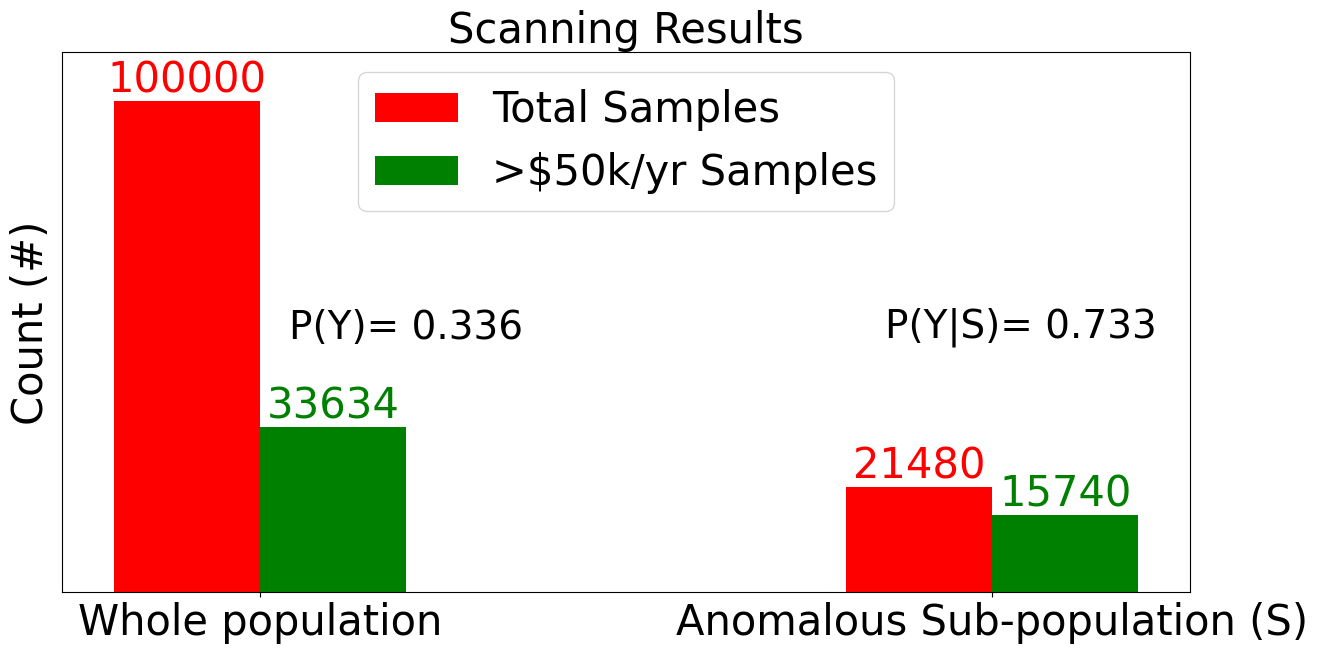

In [7]:
# dff = data.copy()
dff['observed'] = observed
dff['probabilities'] = observed.mean()
describe_subset_autostrat(privileged_subset,dff)

Next, We'll scan for individuals with significantly lower income level than the overall average of `0.33`. We start with a low penalty value and observe the subset we find.

In [8]:
unprivileged_subset = bias_scan(data=data, observations=observed, scoring='Bernoulli', overpredicted=True,penalty=10,num_iters=1)
print(unprivileged_subset)


({'AGEP': ['20 - 30', '30 - 50', '50 - 70', 'teen'], 'WKHP': ['0 - 10', '10 - 20', '20 - 30'], 'SCHL': ['1 or more years of college credit but no degree', '12th Grade - no diploma', 'Associate’s degree', 'Bachelor’s degree', 'GED or alternative credential', 'Grade 10', 'Grade 11', 'Grade 6', 'Grade 7', 'Grade 8', 'Grade 9', 'No schooling completed', 'Regular high school diploma', 'Some college but less than 1 year']}, 4862.2218)


Our detected privileged group has a size of 20416 which is 20.416% of the data. 
We observe 0.0487 as the average probability of earning >50k in this subgroup, but our population mean is 0.3363


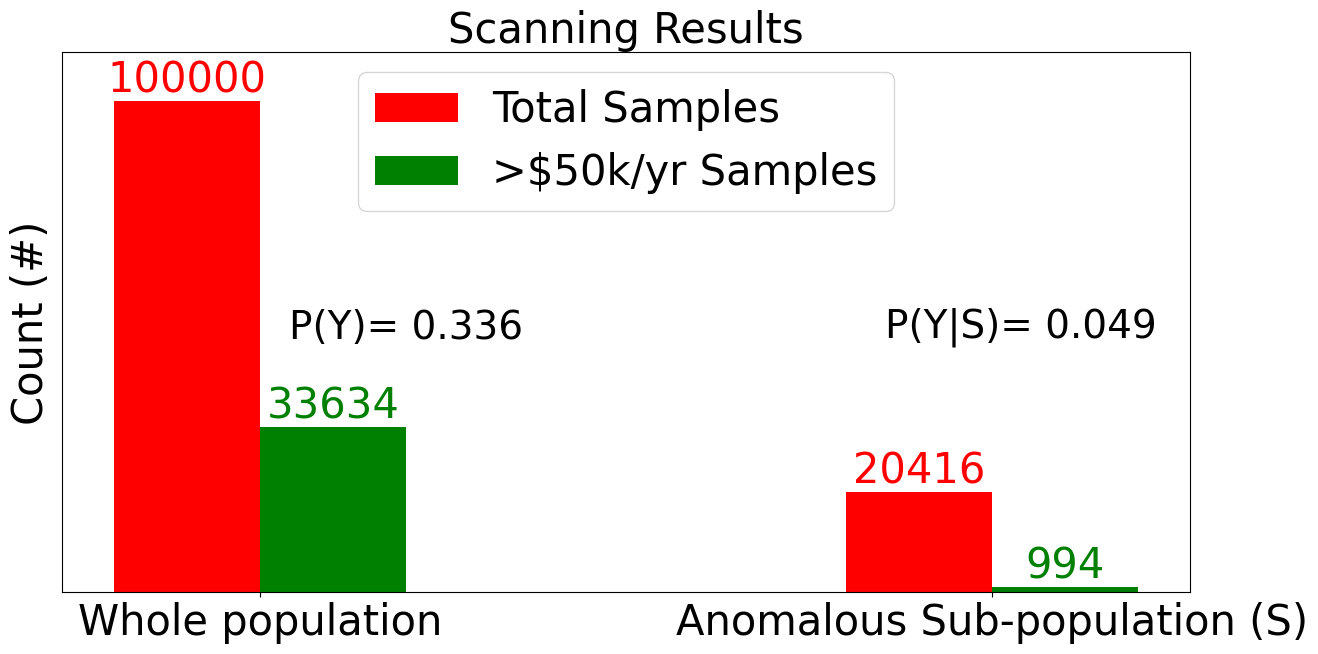

In [9]:
describe_subset_autostrat(unprivileged_subset,dff)

### Penalty variation

We can also vary the penalty value which will affect the description length of the returned subset. Please note that while using a high penalty value reduces the complexity of the returned subset, there is the trade-off of obtaining a less extreme subset (lower bias score)

In [10]:
privileged_subset = bias_scan(data=data, observations=observed, scoring='Bernoulli', overpredicted=True,penalty=1, num_iters=1)
print(privileged_subset)

({'OCCP': [' Gambling cage workers', 'Agricultural and food science technicians', 'Ambulance drivers and attendants, except emergency medical technicians', 'Animal caretakers', 'Animal trainers', 'Artists and related workers', 'Automotive glass installers and repairers', 'Baggage porters, bellhops, and concierges', 'Bakers', 'Barbers', 'Bartenders', 'Bill and account collectors', 'Billing and posting clerks ', 'Bookkeeping, accounting, and auditing clerks', 'Butchers and other meat, poultry, and fish processing workers', 'Carpenters', 'Carpet, floor, and tile installers and finishers', 'Cashiers', 'Cement masons, concrete finishers, and terrazzo workers', 'Chefs and head cooks', 'Childcare workers', 'Cleaners of vehicles and equipment', 'Clergy', 'Coin, vending, and amusement machine servicers and repairers', 'Construction laborers', 'Cooks', 'Counter and rental clerks', 'Couriers and messengers', 'Crossing guards and flaggers', 'Crushing, grinding, polishing, mixing, and blending work

Our detected privileged group has a size of 27559 which is 27.559% of the data. 
We observe 0.07 as the average probability of earning >50k in this subgroup, but our population mean is 0.3363


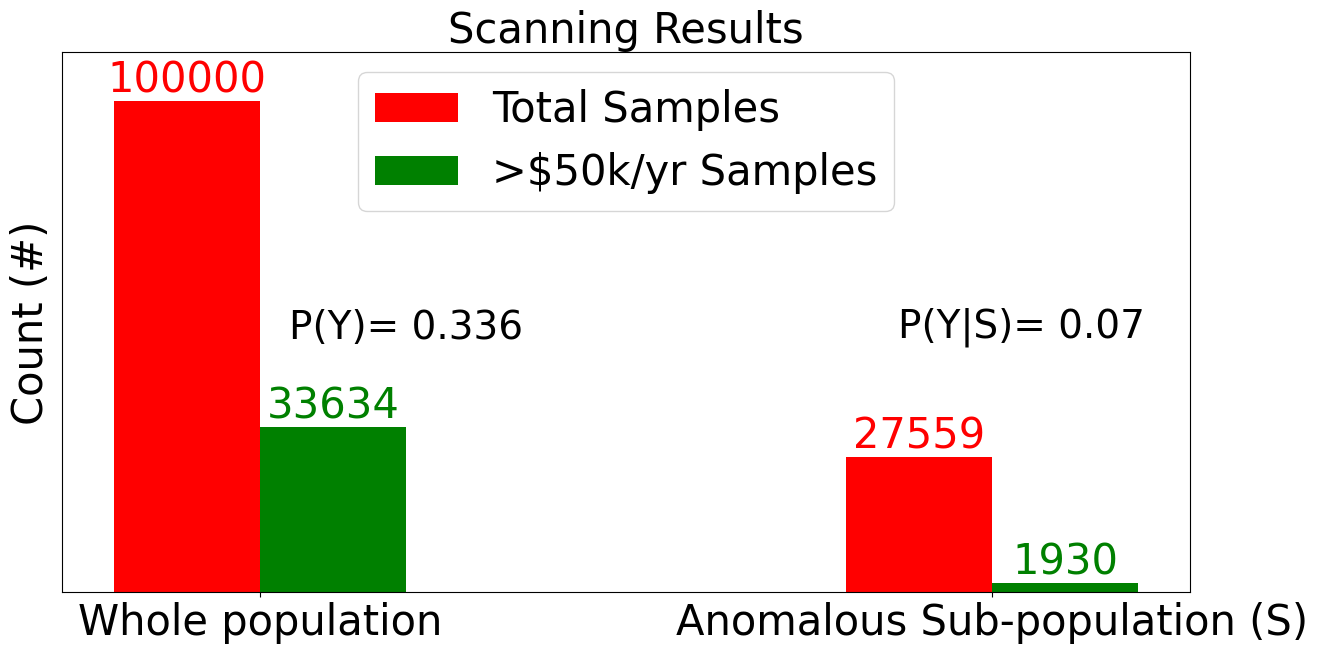

In [11]:
describe_subset_autostrat(privileged_subset,dff)

## Bias scan using Multi-Dimensional Subset Scan (MDSS)

"Identifying Significant Predictive Bias in Classifiers" https://arxiv.org/abs/1611.08292

The goal of bias scan is to identify a subgroup(s) that has significantly more predictive bias than would be expected from an unbiased classifier. There are $\prod_{m=1}^{M}\left(2^{|X_{m}|}-1\right)$ unique subgroups from a dataset with $M$ features, with each feature having $|X_{m}|$ discretized values, where a subgroup is any $M$-dimension
Cartesian set product, between subsets of feature-values from each feature --- excluding the empty set. Bias scan mitigates this computational hurdle by approximately identifing the most statistically biased subgroup in linear time (rather than exponential).




In [12]:

from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score


#### Helper functions to describe results

In [13]:

# transform feature values into numerical codes for computation   
def transform_features(X):
    for feature in X.columns:
        X[feature] = X[feature].astype('category').cat.codes
    return X

# report evaluation metrics
def report(actual, predicted):
    print('F1: ', f1_score(actual, predicted))
    print('AUC-ROC: ', roc_auc_score(actual, predicted))

# describe subset from bias scan 
def describe_subset(subset,data,y, preds):
    y = y.reset_index(drop=True)
    to_choose = data[subset.keys()].isin(subset).all(axis=1)
    to_choose = to_choose.reset_index(drop=True)
    _actual = y.loc[to_choose].copy()
    _preds = preds.loc[to_choose].copy()

    print('Subgroup Results:')
    report(_actual, _preds)
    print()
    print(f"For the anomalous subgroup, the model predicts { _preds.sum()} people to earn >50K but in reality { _actual.sum()} earn this amount")
    print("Our detected subgroup has a size of {}.\nWe observe {} as the mean outcome, but our model predicts a mean outcome of {}"\
    .format(len(_preds), np.round(_actual.mean(),2), np.round(_preds.mean(),2)))
    

### Concept drift
In this section, we train a model on the 2014 US Census Income data and use that model to predict on 2018 data. We then scan the predicted probabilities from the model trained on 2014 data against the actual outcomes from 2018 data. By doing this, we hope to identify a concept drift where the changes in time can be used to assess the performance degradation of the older model.

In [21]:
# extract features and transform data to numeric for the model
# 2014 data
y_2014 = observed
features_2014 = data
X_2014 = features_2014.copy()
X_2014 = transform_features(X_2014)

# 2018 data
y_2018 = dff_2018['observed']
y_2018 = y_2018.reset_index(drop=True)
features_2018 = dff_2018.drop(['observed'], axis = 1)
features_2018 = features_2018.reset_index(drop=True)
X_2018 = features_2018.copy()
X_2018 = transform_features(X_2018)

In [22]:
# Train model on 2014
model_2014 = ExtraTreesClassifier()
model_2014.fit(X_2014, y_2014)
preds_2014 = pd.Series(model_2014.predict(X_2014))

# Predict on 2018 
preds_2018 = pd.Series(model_2014.predict(X_2018))

# evaluate model
print('Global Results (2014):')
report(y_2014,preds_2014)
print()
print("Global results (2018): " )
report(y_2018, preds_2018)

Global Results (2014):
F1:  0.9800843627598674
AUC-ROC:  0.981938296728055

Global results (2018): 
F1:  0.6132120562547977
AUC-ROC:  0.6986709491774388


In [29]:
# scan the priviledged subset
subset, _ = bias_scan(data=features_2018, observations=y_2018, 
          expectations=preds_2018, scoring='Bernoulli', 
          overpredicted=False, penalty=10, num_iters=1)

print()
print('Anomalous Subgroup:\n', subset)


Anomalous Subgroup:
 {'OCCP': [' First-line supervisors of security workers', 'Accountants and auditors', 'Actors', 'Actuaries', 'Administrative services managers', 'Advertising and promotions managers', 'Advertising sales agents', 'Aerospace engineers', 'Agents and business managers of artists, performers, and athletes', 'Agricultural and food science technicians', 'Agricultural inspectors', 'Air traffic controllers and airfield operations specialists', 'Aircraft mechanics and service technicians', 'Aircraft pilots and flight engineers', 'Animal caretakers', 'Animal control workers', 'Architects, except landscape and naval', 'Architectural and civil drafters', 'Architectural and engineering managers', 'Artists and related workers', 'Athletes and sports competitors', 'Audiologists', 'Automotive body and related repairers', 'Automotive service technicians and mechanics', 'Baggage porters, bellhops, and concierges', 'Bailiffs', 'Bakers', 'Barbers', 'Bartenders', 'Bill and account collec

In [30]:
# check model performance on 2014 data
describe_subset(subset,dff_2014,y_2014, preds_2014)

Subgroup Results:
F1:  0.9897485286249331
AUC-ROC:  0.9901818039805275

For the anomalous subgroup, the model predicts 23176 people to earn >50K but in reality 23549 earn this amount
Our detected subgroup has a size of 57821.
We observe 0.41 as the mean outcome, but our model predicts a mean outcome of 0.4


In [31]:
# check model performance on 2018 data
describe_subset(subset,dff_2018,y_2018, preds_2018)

Subgroup Results:
F1:  0.6309827065170958
AUC-ROC:  0.6904397446197508

For the anomalous subgroup, the model predicts 26663 people to earn >50K but in reality 36540 earn this amount
Our detected subgroup has a size of 77329.
We observe 0.47 as the mean outcome, but our model predicts a mean outcome of 0.34


## Summary
This notebook demonstrates how to discover systematic deviations in data or models (predictive bias) for a binary classification case. There are more examples that use other datasets in different domains in demo_mdss_detectors.ipynb found in the open-source [AI-Fairness 360 repository](https://github.com/Trusted-AI/AIF360) examples folder. 